<a href="https://colab.research.google.com/github/eovallemagallanes/Digital-Image-Processing/blob/main/01-INTENSITY-TRANSFORMATION/INTENSITY_TRANSFORMATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REQUIRED PACKAGES

In [ ]:
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider, Checkbox

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku

## **PLOT FUNCTION**

In [ ]:
def show(img, show_hist=True, show_by_channel=False):
    dims = img.shape
    if len(dims) < 2:
        print('Not an image')
        return
    if len(dims) == 2:
        # gray scale image, require aditional last channel
        #print('Expandig last dim')
        img = np.expand_dims(img, -1)
    
    # map to uint8
    img = np.array(img, dtype = np.uint8) 

    channels = img.shape[-1] # last dim is the channel
    if channels == 3:
        labels = ['Red', 'Green', 'Blue']
        colors = ['r', 'g', 'b']
    else:
        labels = ['Gray']
        colors = ['gray']
    if show_hist:
        if show_by_channel and channels == 3:
            fig, axs = plt.subplots(2, channels + 1,
                                       figsize=(12, 6))
            
            # Display original image.
            axs[0, 0].imshow(img)
            axs[0, 0].set_axis_off()
            axs[1, 0].set_axis_off()
            for i in range(channels):
                axs[0, i+1].imshow(img[..., i])
                axs[0, i+1].set_axis_off()

            # Display the histogram.
            for i, (label, color) in enumerate(zip(labels, colors)):
                axs[1, i+1].hist(img[..., i].ravel(), lw=0, bins=256, color=color)
                axs[1, i+1].set_xlim(0, img[..., i].max())
                axs[1, i+1].set(xlabel=label)
                axs[1, i+1].set_yticks([])
        
            plt.show()
        else:
            # Display the image.
            fig, axs = plt.subplots(1, channels + 1,
                                        figsize=(12, 3))
        
            if channels == 3:
                axs[0].imshow(img)
            if channels == 1:
                axs[0].imshow(img[..., 0], cmap='gray')
            axs[0].set_axis_off()
        
            # Display the histogram.
            for i, (label, color) in enumerate(zip(labels, colors)):
                axs[i+1].hist(img[..., i].ravel(), lw=0, bins=256, color=color)
              
        
            plt.show()
    else:
        # Display the image.
        fig = plt.figure(figsize=(3, 3))
        if channels == 3:
            plt.imshow(img)
        if channels == 1:
            plt.imshow(img[..., 0], cmap='gray')
        plt.axis('off')
    


# 01. INTENSITY TRANSFORMATION

## READ IMAGE

In [ ]:
# working in range [0.0, 255.0]
img = skimage.img_as_float(skid.astronaut())*255.0

#   The weights used in this conversion are calibrated for contemporary
#   CRT phosphors::
#   Y = 0.2125 R + 0.7154 G + 0.0721 B
#   return values in the range of the input image
gray_img = skic.rgb2gray(img)

## SHOW RGB IMAGE

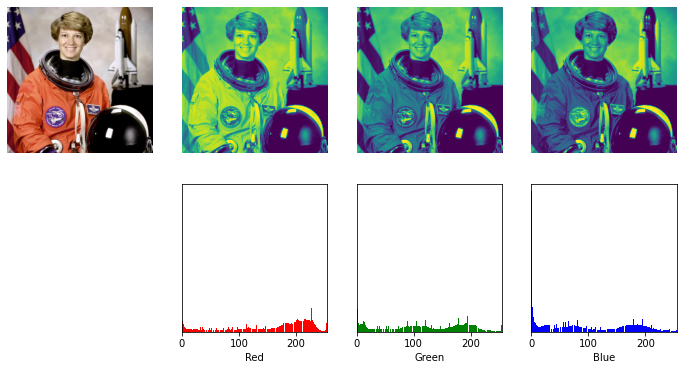

In [ ]:
show(img, show_hist=True, show_by_channel=True)

## SHOW GRAY SCALE IMAGE

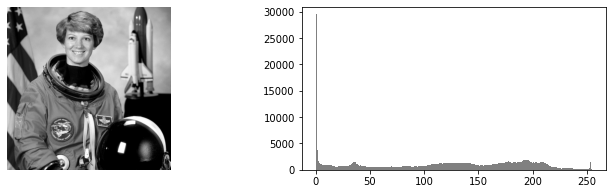

In [ ]:
show(gray_img, show_hist=True, show_by_channel=False)

## LINEAR TRANSFORMATION

In [ ]:
def trans_lineal(img, Ymin, Ymax):
    print(Ymin, Ymax)
    Imax = img.max()
    Imin = img.min()
    m = (Ymax - Ymin)/(Imax - Imin)
    img_out = m*(img - Imin) + Ymin
    
    show(img_out)
    #return m*(img - Imin) + Ymin

In [ ]:
Ymin_widget = FloatSlider(min=0.0, max=255.0, step=1.0, value=0.0, continuous_update=False)
Ymax_widget = FloatSlider(min=0.0, max=255.0, step=1.0, value=255.0, continuous_update=False)

interact(trans_lineal,img=fixed(img), Ymin=Ymin_widget, Ymax=Ymax_widget);

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Ymin', max=255.0, step=1.0)…

## STEP TRANSFORMATION

In [ ]:
def trans_step(img, threshold):
    H, W = img.shape[0], img.shape[1]
    #show(img)
    img_out = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            img_out[i, j] = 1.0 if img[i, j] > threshold else 0.0
    
    show(img_out, show_hist=False)

In [ ]:
threshold_widget = FloatSlider(min=0.0, max=255.0, step=1.0, value=90.0, continuous_update=False)

interact(trans_step,img=fixed(gray_img), threshold=threshold_widget);

interactive(children=(FloatSlider(value=90.0, continuous_update=False, description='threshold', max=255.0, ste…

## LOGARITMIC TRASFORMATION

In [ ]:
def trans_log(img):
    # Apply log transform. 
    c = 255/(np.log(1 + np.max(img))) 
    log_transformed = c * np.log(1 + img)

    show(log_transformed, show_hist=True)

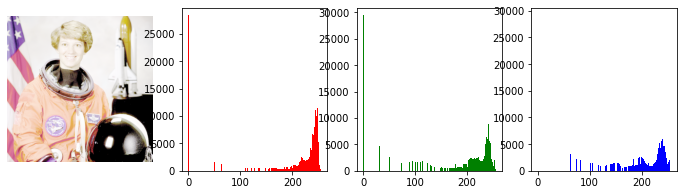

In [ ]:
trans_log(img)

## GAMMA TRANSFORMATION

In [ ]:
def trans_gamma(img, gamma, correction):
    img_shape = img.shape
    gamma_corrected = img.copy()
    if len(img_shape) == 3: # 3 channels
        img_r = img[..., 0]
        img_g = img[..., 1]
        img_b = img[..., 2]
        # intensity image, by avering the 3 channels
        #img_intensity = (img_r + img_g + img_b ) / 3.0 + 1e-6 # add epsilon to avoid zero divisions in gamma correctiom
        img_intensity = img.mean(axis = 2) + 1e-6

        if correction:
            img_gr = img_intensity * (img_r / img_intensity)**(1.0/gamma)
            img_gg = img_intensity * (img_g / img_intensity)**(1.0/gamma)
            img_gb = img_intensity * (img_b / img_intensity)**(1.0/gamma)

            #gamma_corrected[..., 0] = img_gr
            #gamma_corrected[..., 1] = img_gg
            #gamma_corrected[..., 2] = img_gb

            img_gr = np.clip(img_gr, 0, 255)
            img_gg = np.clip(img_gg, 0, 255)
            img_gb = np.clip(img_gb, 0, 255)

            gamma_corrected = np.stack([img_gr, img_gg, img_gb], axis=-1)
            #print(gamma_corrected.shape)
        else:
            gamma_corrected = np.array(255.0*(img / 255.0) ** (1/gamma))
    else:
        gamma_corrected = np.array(255.0*(img / 255.0) ** (1/gamma))
    
    show(gamma_corrected, show_hist=True)

In [ ]:
gamma_widget = FloatSlider(min=0.0, max=4.0, step=0.2, value=2.0, continuous_update=False)
gamma_corection_widget = Checkbox( value=False, description='Gamma color correction', disabled=False, indent=False)

interact(trans_gamma,img=fixed(img), gamma=gamma_widget, correction=gamma_corection_widget);

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='gamma', max=4.0, step=0.2),…

In [ ]:
gamma_widget = FloatSlider(min=0.0, max=4.0, step=0.2, value=2.0, continuous_update=False)
gamma_corection_widget = Checkbox( value=False, description='Gamma color correction', disabled=False, indent=False)

interact(trans_gamma,img=fixed(gray_img), gamma=gamma_widget, correction=gamma_corection_widget);

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='gamma', max=4.0, step=0.2),…

In [ ]:
# gamma transformation avoiding zero division

def trans_gamma2(img, gamma, correction):
    img_shape = img.shape
    gamma_corrected = img.copy()
    if len(img_shape) == 3: # 3 channels
        img_r = img[..., 0]
        img_g = img[..., 1]
        img_b = img[..., 2]
        # intensity image, by avering the 3 channels
        #img_intensity = (img_r + img_g + img_b ) / 3.0 
        img_intensity = img.mean(axis = 2) + 1e-6

        if correction:
            corr_factor = img_intensity**(1.0 - 1.0/gamma)
            #img_gr = corr_factor * (img_r)**(1.0/gamma)
            #img_gg = corr_factor * (img_g)**(1.0/gamma)
            #img_gb = corr_factor * (img_b)**(1.0/gamma)

            #gamma_corrected[..., 0] = img_gr
            #gamma_corrected[..., 1] = img_gg
            #gamma_corrected[..., 2] = img_gb

            #gamma_corrected = np.stack([img_gr, img_gg, img_gb], axis=-1)

            gamma_corrected = np.expand_dims(corr_factor, axis=-1) * img**(1.0/gamma) # expand last dim to match the color image array * img**(1.0/gamma)
            gamma_corrected = np.clip(gamma_corrected, 0, 255)

        else:
            gamma_corrected = np.array(255.0*(img / 255.0) ** (1/gamma))
    else:
        gamma_corrected = np.array(255.0*(img / 255.0) ** (1/gamma))
    
    show(gamma_corrected, show_hist=True)

In [ ]:
gamma_widget2 = FloatSlider(min=0.0, max=4.0, step=0.2, value=2.0, continuous_update=False)
gamma_corection_widget2 = Checkbox( value=False, description='Gamma color correction', disabled=False, indent=False)

interact(trans_gamma2,img=fixed(img), gamma=gamma_widget2, correction=gamma_corection_widget2);

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='gamma', max=4.0, step=0.2),…

## HISTOGRAM EQUALIZATION

In [ ]:
# raw implemantation for histogram & cumulative histogram
def histogram(img, normalize=False):
    img = np.array(img, dtype = np.uint8).ravel()
    H = img.shape[0]
    h = np.zeros((256))
    for i in range(H):
            pix = img[i]
            h[pix] += 1
    
    if normalize:
        h = h / H 
    return h



def cum_histogram(img, h_norm=None):
    if h_norm is None:
        h_norm = histogram(img, True)
    h_cum = np.ones((256))
    h_cum[0] = h_norm[0]
    for k in range(1,256):
        h_cum[k] = h_norm[k] + h_cum[k-1]

    return h_cum


In [ ]:
# histogram equalization
def equalize(img, h_cum=None):
    if h_cum is None:
        h_cum = cum_histogram(img)
    img = np.array(img, dtype = np.uint8)
    H, W = img.shape
    img_eq = img.copy()
    for i in range(H):
        for j in range(W):
            pix = img[i, j] 
            prob = h_cum[pix]
            img_eq[i, j] = round(255. * prob)

    return img_eq

def histogram_eq(img, h_cum=None, correction=False):
    img_shape = img.shape
    img_eq = img.copy()
    # check if is a color image
    if len(img_shape) == 3:
        #img_r = img[..., 0]
        #img_g = img[..., 1]
        #img_b = img[..., 2]

        img_r, img_g, img_b = np.squeeze(np.dsplit(img, img.shape[-1])) # annother way to split channels: (H, W)

        img_intensity = img.mean(axis = 2) 
        if correction:
            h_cum = cum_histogram(img_intensity)
        else:
            h_cum=None

        img_er = equalize(img_r, h_cum)
        img_eg = equalize(img_g, h_cum)
        img_eb = equalize(img_b, h_cum)

        #img_eq[..., 0] = img_er
        #img_eq[..., 1] = img_eg
        #img_eq[..., 2] = img_eb

        img_eq = np.stack([img_er, img_eg, img_eb], axis=-1)

    else:
        img_eq = equalize(img)

    return img_eq


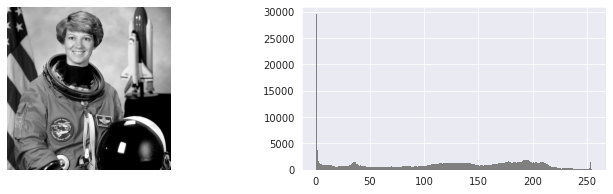

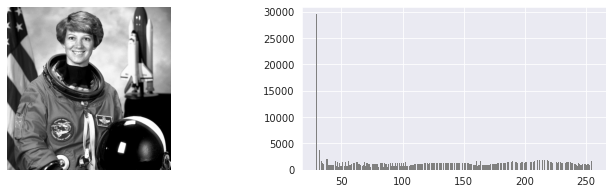

In [ ]:
img_eq = histogram_eq(gray_img)
show(gray_img)
show(img_eq)

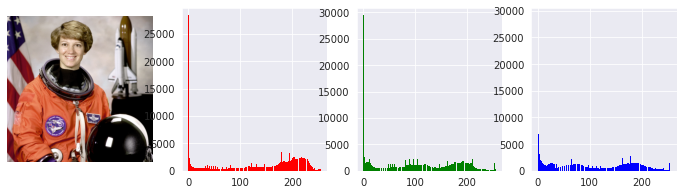

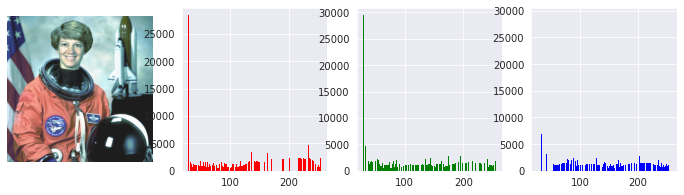

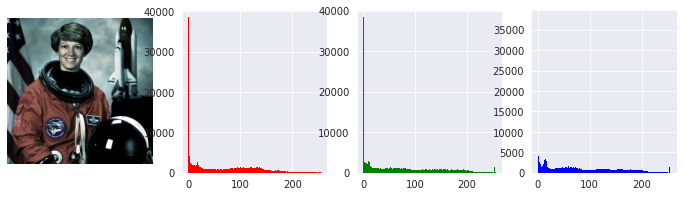

In [ ]:
color_img_eq = histogram_eq(img=img)
show(img)
show(color_img_eq)

color_img_eq2 = histogram_eq(img=img, correction=True)
show(color_img_eq2)